In [9]:
import warnings
import os
from pathlib import Path
import glob
import pandas as pd
import numpy as np
from scipy import stats
import re

pd.options.mode.copy_on_write = True
'''
Defining relative location of data to current script and other path variables. 
Data file must be placed in a folder labeled data in the same folder as this script.
'''

file_target = '20230714_kinetic_plate_1'

absolute_path = Path().absolute()
data_location = os.path.join(absolute_path, 'xlsx/')
results_location = os.path.join(absolute_path, 'results', file_target)
if not os.path.exists(results_location):
    os.makedirs(results_location)

print("Reading data files from: ", data_location)


'''Defining helper methods and functions to be used later'''
'''Used to retrieve rows by lookup of a value in another column'''
def rowtrieve(self, column, target):
    return self.loc[self[column] == target]
pd.DataFrame.rowtrieve = rowtrieve

'''Generates a list of possible well names'''
def char_range(letter1, letter2):
    for index in range(ord(letter1), ord(letter2)+1):
        yield chr(index)

"""
This block generates well_list, which the algorithm can use to differentiate well names from other columns.
It includes all default well names on a 96- or 384-well plate.
"""  
letters = [letter for letter in char_range('A','P')]
numbers = [str(x) for x in range(1,25)]
well_list = [str1 + str2 for str1 in letters for str2 in numbers]

'''
This function rounds small time discrepancies recorded during the gathering of data across the plate
in order to standardize analyzed timepoints across wells.
'''
def HMS_rounder(timestring, unit='min'):
    timestring = str(timestring)
    h,m,s = timestring.split(':')
    h,m,s = (float(val) for val in [h,m,s])
   
    s_round = round(s/60)
    m_round = round((m+s/60)/60)
    
    if unit == 'min':
        return h+(m+s_round)/60
    
    if unit == 'hour':
        return h+m_round

def time_parser(string):
    
    return_value = None
    try:
        return_value = string.hour + string.minute/60 + string.second/3600
    except:
        try:
            splitstring = string.split('_')[-1]
            unit = splitstring.lstrip('0123456789')
            value = splitstring[:-len(unit)]

            if unit == 'h':
                return_value = float(value)
            if unit == 'm':
                return_value = float(value)/60
            if unit == 's':
                return_value = float(value)/3600
        except:
            pass

    return return_value

'''
Following functions for Excel import functionalities
'''

'''
This function is a lightweight, first-pass function to gather overall file info, export format, 
and user-given sample variable assignments (from second sheet of Excel doc)
'''
def xl_info_gather(file, experiment_title):
    with open(file):
        xlsx = pd.ExcelFile(file)
        xl_read = pd.read_excel(xlsx)
        export_format = xl_read.iloc[0,3]
        
        sample_dicts = pd.read_excel(file, sheet_name=1, header=1)
    
    return xlsx, xl_read, sample_dicts, export_format


def kinetic_exporter(xl_read, local_df, sample_dicts):

    """
    Start Excel read comprehension and reorganization into tidy format.
    header column contains "Plate:" and "~End" pointers that demarcate the start and end rows of data,
    from which start and end indices can be derived. A file containing multiple row zones delimited by
    these pointers should seamlessly find all data. By default, program expects data to begin 2 rows after
    "Plate:' and end 2 rows before "~End". 
    """    
    header = xl_read.columns[0]
    start_index = xl_read.rowtrieve(header, 'Plate:').index
    end_index = xl_read.rowtrieve(header, '~End').index

    """
    Tabular data in well-by-well column format e.g. [Time, Temperature, A1, A2, ..., H12] is melted to
    reorganize 'Well' into a singular column with measurement 'Value' to be in tidy format
    with each data value having its own row.

    This block also implements some cleaning and standardizing functions, such as applying the mode Temperature
    and time rounding function. Note that if these standardizing functions are turned off, it will negatively 
    impact the behavior of later groupby functions that rely on certain variables to remain constant across measurements.

    Assumptions: 
    Time in HH:MM:SS format
    Assay (e.g., 'Absorbance', 'Fluorescence') 5 cells to the right of 'Plate:'
    Static temperature (applying mode Temperature only intended to standardize for <~1C fluctuations)
    """
    idfs = [local_df]
    for start, end in zip(start_index,end_index):
        # Restructuring Excel formatted data
        idf = pd.DataFrame(data = xl_read.iloc[start+2:end-1].values, columns = xl_read.iloc[start+1].values)
        sample_vars = [value for value in idf.columns if value not in well_list]
        well_vars = [value for value in idf.columns if value in well_list]
        idf = pd.melt(idf, id_vars = sample_vars, value_vars = well_vars)

        # Cleaning, info-gathering, and standardizing functions
        idf = idf.rename(columns={'Temperature(¡C)': 'Temperature', 'variable': "Well", 'value': 'Value'})
        if 'Temperature' in idf.columns:
            idf['Temperature'] = idf['Temperature'].mode().values[0]
        idf['Assay'] = xl_read.iat[start, 5] # modify this line if needing a different lookup location for Assay
        idf['Time'] = idf['Time'].apply(HMS_rounder)
        idf = idf.sort_values(by=['Well', 'Time'])
        
        # Apply sample conditions to idf and collect it for future concatenation into local_df
        idf = idf.merge(sample_dicts, how = 'inner', on = 'Well')
        
        idfs.append(idf)
    
    local_df = pd.concat(idfs)
        
    return local_df


'''
Wrapper function for possible differences in export format 
Records each analyzed xlsx file as its own 'Experiment'

Includes a toehold for customization, as many different Excel plate export formats exist
'''
def raw_data_excel_import(file, xlsx_file = True):
    
    experiment_title = file.split('\\')[-1].split('.')[0]
    print('Analyzing file {}'.format(experiment_title))

    if xlsx_file == True:
        xlsx, xl_read, sample_dicts, export_format = xl_info_gather(file, experiment_title)      
        local_df = pd.DataFrame()
        
        if export_format == 'TimeFormat':
            local_df = kinetic_exporter(xl_read, local_df, sample_dicts)

        elif export_format == 'YourCustomFormat':
            pass # Call your custom export formatting function here
            # It should take the same inputs and return the same outputs as kinetic_exporter()
            # e.g.: local_df = custom_function(xl_read, local_df, sample_dicts)
            
    local_df['Experiment'] = experiment_title
    
    return local_df

'''
This function removes suspected contaminated blanks before averaging for background subtraction.
Different media types are evaluated separately.
Currently, it uses a statistic of z-score > 2 OD600 value compared to all blanks on the same plate to classify.
Also drops a blank with OD600 > 0.5.
Statistical method could be improved.

Additionally, it currently filters out all rows from df_reps that are not labeled 'Absorbance' under 'Assay'.
This behavior is acceptable for a script that strictly evaluates growth rates
but may be undesirable for other types of analysis (e.g., fluorescence).
'''
def data_cleaner(df):
    '''Removes wells labeled 'drop' from analysis'''
    df = df.loc[df.loc[df['Sample'].str.strip() != 'drop'].index]
    cleaned_dfs = []

    for keys, media_df in df.groupby(['Media', 'Experiment']):
        
        blanks_abs_df = media_df.rowtrieve('Sample','blank').rowtrieve('Assay','Absorbance')
        blanks_abs_df.loc[:, 'Value'] = pd.to_numeric(blanks_abs_df.Value, errors='coerce').dropna()

        """
        This block finds and removes suspected contaminated blank wells. 
        It also raises an error if no passable blank wells are found 
        and warns the user if the number of passable blank wells is 3 or lower.

        You can turn this behavior off by switching the find_contamination variable to False.
        """
        find_contamination = True
        if find_contamination:
            contaminated_blanks = blanks_abs_df[((stats.zscore(blanks_abs_df['Value'].astype(float))) > 2) 
                | (blanks_abs_df['Value'] > 0.5)]['Well'] # modify the values in this assignment to tune thresholds
            if not contaminated_blanks.empty:
                print('Blank wells {} of media type {} in experiment {} determined to be contaminated and were removed from analysis.'
                      .format(set(contaminated_blanks.values), keys[0], keys[1]))
            if len(blanks_abs_df.loc[~blanks_abs_df['Well'].isin(contaminated_blanks.values)]) == 0:
                raise ValueError('No passable blank wells found')
            elif len(blanks_abs_df.loc[~blanks_abs_df['Well'].isin(contaminated_blanks.values)]) < 4:
                warnings.warn('Number of passable blank wells is low')
            media_df = media_df.loc[~media_df['Well'].isin(contaminated_blanks.values)]
        
        '''
        Background subtraction: important that blank wells are labeled 'blank' on the excel sheet. 
        Subtracts different media types separately and performs the calculation independently for each plate. 
        '''
        abs_df = media_df.rowtrieve('Assay', 'Absorbance').reset_index(drop=True)
        abs_df['Value'] = abs_df['Value'] - np.mean(abs_df.rowtrieve('Sample', 'blank')['Value'])

        cleaned_dfs.append(abs_df)
        
    df_reps = pd.concat(cleaned_dfs)
    
    '''Removes blank wells from df after their function to background subtract has been carried out'''
    df_reps = df_reps.loc[df_reps['Sample'] != 'blank']

    return df_reps


df_reps = pd.DataFrame()

'''
raw_data_excel_import function gathers certain variables from xlsx datasheets and pulls on helper functions
to output data into tidy-formatted pandas dataframe, df_reps

Following block iterates through relevant data files and aggregates them all into df_reps, with unique ID by 'Experiment' 
'''
for file in sorted(glob.glob(data_location + '*.xls*'), key = lambda x: int(re.sub('\\D', '', x))):
    if '.xlsx' in file and file_target in file:
        df_reps = pd.concat([df_reps, raw_data_excel_import(file)], ignore_index=True) 
    '''
    I tried to get pandas to read xls files directly but some computer jank occurred 
    that I don't have time to solve so it's best to just convert files to xlsx.
    '''
    if '.xls' in file and '.xlsx' not in file:
        print('Hello, please do a simple export of your .xls raw data files to .xlsx')
        print('Here\'s the file you need to convert: {}'.format(file))

df_reps = data_cleaner(df_reps)
print('\n Here are some descriptive statistics of df_reps:')
print(df_reps.describe(include='all'))

print('\n Here are some example rows from df_reps:')
print(df_reps)


Reading data files from:  C:\Users\samgo\OneDrive\Documents\Wilson Lab\Data\Plate Reader - Copy\xlsx/
Analyzing file 20230714_kinetic_plate_1
Blank wells {'C12', 'C6', 'D12', 'B12', 'A12', 'A6'} of media type M9 in experiment 20230714_kinetic_plate_1 determined to be contaminated and were removed from analysis.
Blank wells {'F12', 'H6', 'F6'} of media type MSM in experiment 20230714_kinetic_plate_1 determined to be contaminated and were removed from analysis.

 Here are some descriptive statistics of df_reps:
                Time  Temperature   Well         Value       Assay   Sample  \
count   10875.000000      10875.0  10875  10875.000000       10875    10875   
unique           NaN          NaN     75   5096.000000           1        2   
top              NaN          NaN     A1      0.338873  Absorbance  lacA R+   
freq             NaN          NaN    145     11.000000       10875     5800   
mean       12.000000         30.0    NaN           NaN         NaN      NaN   
std        

In [57]:
from math import log
import math
import numpy as np
import time
import functools
warnings.filterwarnings('ignore', category=RuntimeWarning)

'''Defining key lists for later use'''
parameter_names = ['Growth rate (/hr)','logT Y-intercept','R2','XTimeStart','XTimeStop']
constant_cols = df_reps.columns.difference(['Time','Value'])

'''Timer decorator'''
def timer(func):
    @functools.wraps(func)
    def wrapper(*args, **kwargs):
        t0 = time.perf_counter()
        value = func(*args, **kwargs)
        t1 = time.perf_counter()
        print('Function {} took {:.4f} seconds to complete'.format(func.__name__, t1-t0))
        return value
    return wrapper

def well_fitter(df_kinetic):
    '''
    This code tests "windows" of integers numbers of successive timepoints (window_size) for their fit 
    to a linear regression of time (x_data) v. log-transformed OD600 (y_data). The function does the log transform itself,
    so y_data should be given in terms of raw OD600 values.

    The input x_data and y_data are for one well. 
    Extrapolating this function to the entire plate is the job of the wrapper function.

    I force the fit to work over an OD600 window that corresponds to typical exponential phase by:
    1) forcing an e^1.5 (~4.5)-fold increase between yStart and yStop values (filtering out non-exponential phase fits)
    2) forcing a minimum value of e^-3 (~0.05) as the yStop value (filtering out fits from noise at low absorbances)
    3) forcing a fit R^2 value of >0.99 in order to classify as a valid fit to filter out fitting to subpar data
    4) forcing a minimum fit window of 100 minutes (i.e., 10 timepoints spaced at 10 minutes each)
    
    These values may need to be shifted depending on the setup.
    
    '''
    
    def find_linear_regime(x_data, y_data, window_size):
        """
        This function tests a single window size over the entire range of data 
        and returns the best linear regression fit for that window as determined by R value.
        
        Growth data should be supplied to this function in their raw (non-transformed) form.
        """
        def fast_batch_linregress(X_windows, Y_windows):
            """ Perform linear regression on all windows simultaneously 
            using numpy sliding windows for fast computation. """
            n = X_windows.shape[1]

            '''Compute sums across each window'''
            sum_x = X_windows.sum(axis=1)
            sum_y = Y_windows.sum(axis=1)
            sum_x2 = (X_windows**2).sum(axis=1)
            sum_y2 = (Y_windows**2).sum(axis=1)
            sum_xy = (X_windows * Y_windows).sum(axis=1)

            '''Calculate slope and intercept for each window'''
            slopes = (n * sum_xy - sum_x * sum_y) / (n * sum_x2 - sum_x**2)
            intercepts = (sum_y - slopes * sum_x) / n

            '''Calculate R² values'''
            r_numerator = n * sum_xy - sum_x * sum_y
            r_denominator = np.sqrt((n * sum_x2 - sum_x**2) * (n * sum_y2 - sum_y**2))
            r_values = r_numerator / r_denominator
            r_squared = r_values**2

            return slopes, intercepts, r_squared
        
        x_windows = np.lib.stride_tricks.sliding_window_view(x_data, window_size)
        y_windows = np.lib.stride_tricks.sliding_window_view(y_data, window_size)
        
        '''Run batch linear regression on all windows'''
        slopes, intercepts, r_squared = fast_batch_linregress(x_windows, y_windows)
         
        '''Apply filtering criteria to all windows simultaneously'''
        valid_growth = (y_windows[:, -1] - y_windows[:, 0] > 1.5) & (y_windows[:, -1] > -3)
        valid_fits = r_squared > 0.99
        valid_windows = valid_growth & valid_fits
        
        
        '''Find the best fit by R²'''
        if np.any(valid_windows):
            best_idx = np.argmax(r_squared[valid_windows])
            best_window_fit = [slopes[valid_windows][best_idx], intercepts[valid_windows][best_idx], r_squared[valid_windows][best_idx],
                    x_windows[valid_windows][best_idx][0], x_windows[valid_windows][best_idx][-1],]
            return best_window_fit
        
        else:
            return []
        
    '''Deriving measurement interval from time data'''
    total_culture_time = int(math.floor(df_kinetic['Time'].max()-df_kinetic['Time'].min()))
    interval = total_culture_time/(df_kinetic['Time'].count()-1)

    '''
    Setting possible window sizes (i.e., number of timepoints analyzed together) from time parameters.
    min_window has lower bounds of 100 minutes and 8 timepoints.
    max_window had upper bounds of 100 hours and all timepoints.
    '''
    min_window = max(math.floor(100/60/interval), 8)
    max_window = min(math.floor(100/interval), df_kinetic['Time'].count())

    '''Defining variables that will be passed for analysis'''
    X = df_kinetic['Time'].astype('float').reset_index(drop=True)
    Y = df_kinetic['Value'].astype('float').reset_index(drop=True)
    logY = np.log(Y)
    
    '''Iterating through and finding best fits for all allowed window sizes'''
    well_fits = []
    for window_size in range(min_window,max_window,1):
        window_fit = find_linear_regime(X, logY, window_size)
        if window_fit:
            well_fits.append(window_fit)

    '''Retaining descriptive variables and restructuring for eventual merge into df_fits'''
    descriptors = df_kinetic[constant_cols].drop_duplicates().T.squeeze(axis=1)
    expt_well = descriptors[['Experiment','Well']]
    other_index = descriptors.index.difference(['Experiment','Well'])
    other_descriptors = descriptors[other_index]

    '''
    If-else to insulate from cases where all windows failed to provide an acceptable fit,
    wherein fit parameters will be added to df_fits as NaN and sample descriptors will be maintained.

    If acceptable fits exist, the fit with the highest R^2 value is identified for addition to df_fits.
    '''
    if well_fits:
        well_array = np.array(well_fits)
        best_idx = np.argmax(well_array[:,2])
        best_fit = pd.Series(well_array[best_idx], name = descriptors.name, index = parameter_names)
        
    else:
        best_fit = pd.Series(name = descriptors.name, index = parameter_names)

    best_fit = pd.concat([expt_well, best_fit, other_descriptors], axis=0)
        
    return best_fit
    
'''
This function iterates through each well of each plate of each experiment 
and uses the well_fitter function on it.
'''
@timer
def plate_absorbance_fitter(df):
    df_abs = df.rowtrieve('Assay','Absorbance')
    fits_list = []
    for keys,group in df_abs.groupby(['Well', 'Experiment']):
        fit = well_fitter(group)
        if not fit.empty:
            fits_list.append(fit)

    '''Build df_fits then sort by (1) experiment, then (2) well order.'''
    df_fits = pd.DataFrame(fits_list)     
    df_fits['Well'] = pd.Categorical(df_fits['Well'], ordered=True, categories = well_list)
    df_fits.sort_values(by=['Experiment','Well'], inplace=True)
    
    cols = df_fits.columns.tolist()

    return df_fits

df_fits = plate_absorbance_fitter(df_reps)

'''This block derives df_means, which provides mean and standard deviation across replicates of fit parameters, from df_fits'''
'''Defining aggregation functions'''
agg_dict = dict.fromkeys(parameter_names,['mean','std'])
agg_dict['Well'] = lambda x: x.tolist()

'''Building df_means, a DataFrame that aggregates df_fits'''
replicate_parameters = [par for par in constant_cols if par != 'Well']
df_means = df_fits.groupby(replicate_parameters).agg(agg_dict).rename(columns={'Well':'Wells'})
df_means['Replicates with valid fits'] = df_fits.groupby(replicate_parameters)[parameter_names[0]].count()
df_means['Average Doubling Time (hrs)'] = np.log(2)/df_means.loc[:,(parameter_names[0],'mean')]

'''Export fit results to an Excel file under the ../results/(your file_target)/ folder'''
df_fits.to_excel(results_location + '/Best fits by well.xlsx', index=False)
df_means.to_excel(results_location + '/Mean fits by grouped replicates.xlsx')
print('Find individual fit and replicate-grouped parameters in ../results/{}/'.format(file_target))

Function plate_absorbance_fitter took 1.9717 seconds to complete
Find individual fit and replicate-grouped parameters in ../results/20230714_kinetic_plate_1/


In [25]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
fig, ax = plt.subplots()
def update(i):
    ax.clear()
    x = np.linspace(0, 10, 100)
    y = np.sin(x + i / 10)
    ax.plot(x, y)
    ax.set_xlim(0, 10)
    ax.set_ylim(-1, 1)
    ax.set_title(f"Frame {i}")
ani = animation.FuncAnimation(fig, update, frames=50, interval=100)
ani.save("results/animation.gif")

(array([ 1.,  0.,  0.,  0.,  0.,  0.,  3.,  9., 13.,  5.]),
 array([-9.70245472, -9.11821279, -8.53397085, -7.94972892, -7.36548699,
        -6.78124506, -6.19700313, -5.6127612 , -5.02851926, -4.44427733,
        -3.8600354 ]),
 <BarContainer object of 10 artists>)

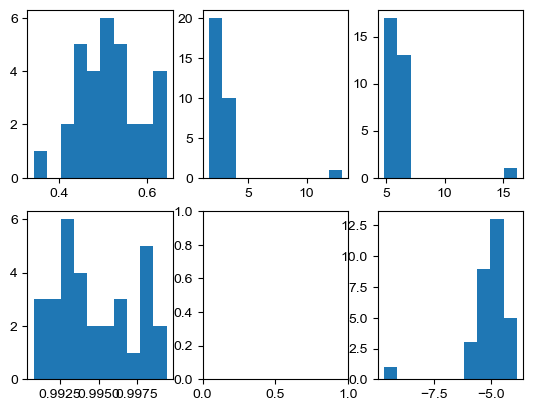

In [128]:
"""
Diagnostic plots:

These plots 
"""

import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 3)
axs[0,0].hist(df_fits['Growth rate (/hr)'], title='Growth rate)
axs[0,1].hist(df_fits['XTimeStart'])
axs[0,2].hist(df_fits['XTimeStop'])
axs[1,0].hist(df_fits['R2'])
axs[1,2].hist(df_fits['logT Y-intercept'])


# plt.title('Window Sizes')
# df_means = means_stds_calculator(df_fits)
# print(df_means)
# df_reps.pivot(index = 'Well', columns = 'Value')

In [130]:
import numpy as np
from statistics import stdev

def param_means_stds(df_param, dict_samples):
    """
    Input: df_sparams as generated by the curve_fitter function
    Outputs: dataframes for each curve fit parameter average and standard deviation, grouped by sample
    """
    df_means = pd.DataFrame(index = days, columns = samples)
    df_stds = pd.DataFrame(index = days, columns = samples)
    for sample in dict_samples:
        for day in df_means.index:
            df_means[sample].loc[day] = df_param[dict_samples[sample]].loc[day].mean()
        for day in df_stds.index:
            df_stds[sample].loc[day] = df_param[dict_samples[sample]].loc[day].std()
        
    return df_means, df_stds

df_k_means_stds = param_means_stds(df_fits, dict_samples)


NameError: name 'dict_samples' is not defined

In [186]:
rates = [0.1,1,2,3,4]
doubles = np.log(2)/rates

avg_rate = sum(rates)/len(rates)
avg_double = sum(doubles)/len(doubles)

derived_avg_double = np.log(2)/avg_rate

print(derived_avg_double)
print(avg_double)

0.3431421685940323
1.675105686353201


<Figure size 640x480 with 0 Axes>

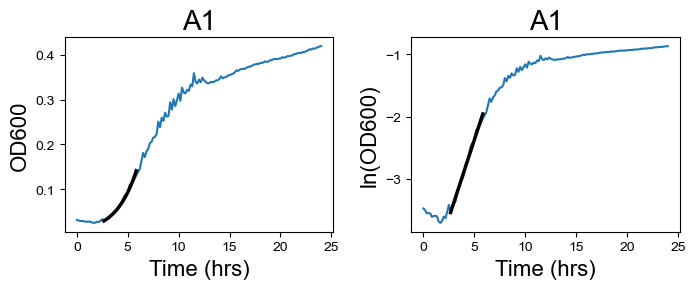

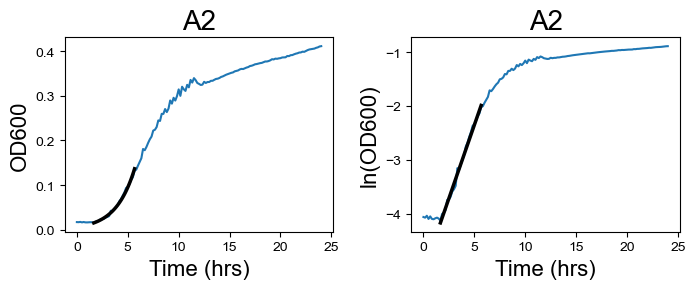

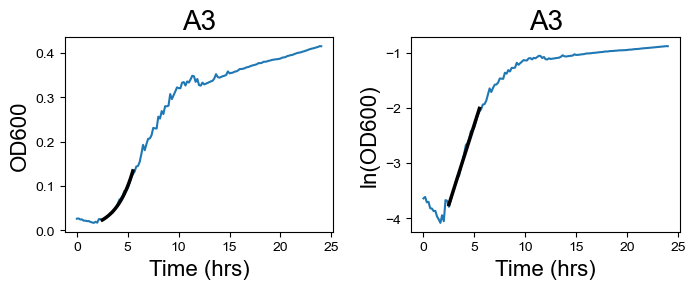

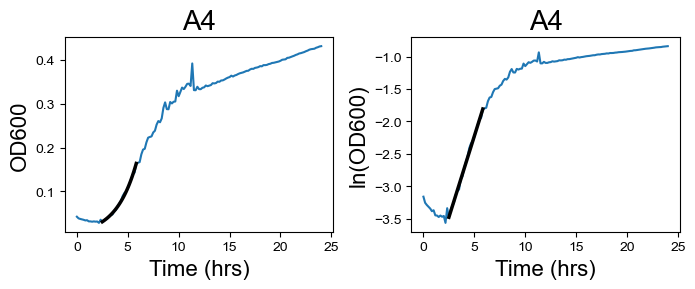

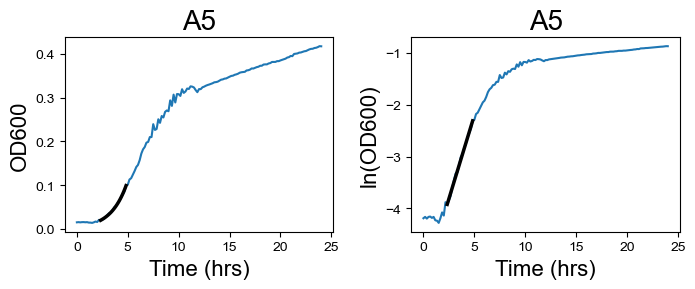

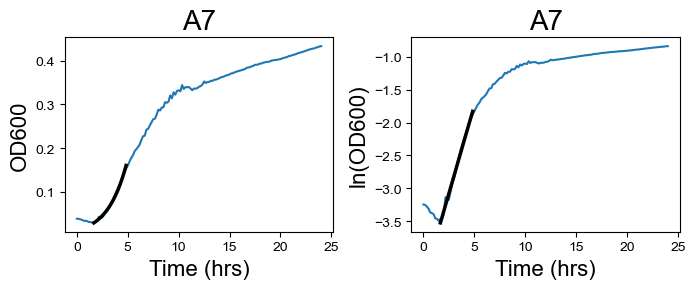

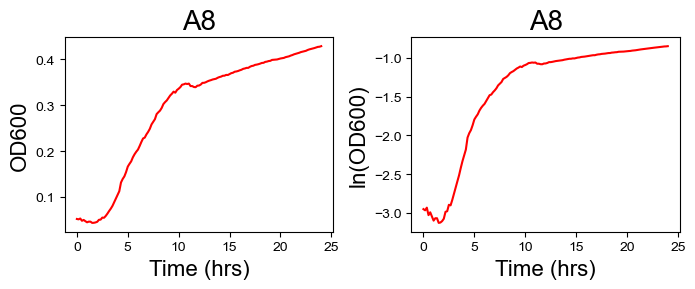

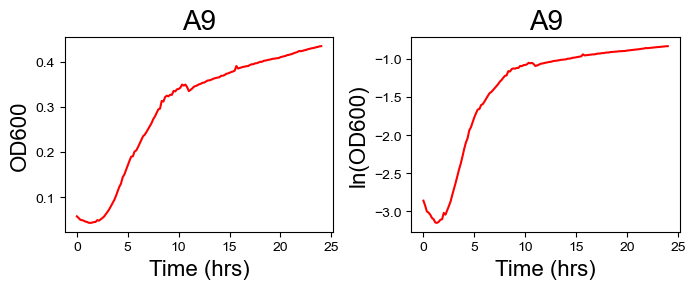

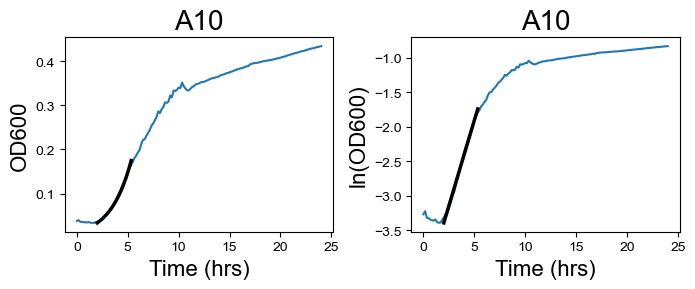

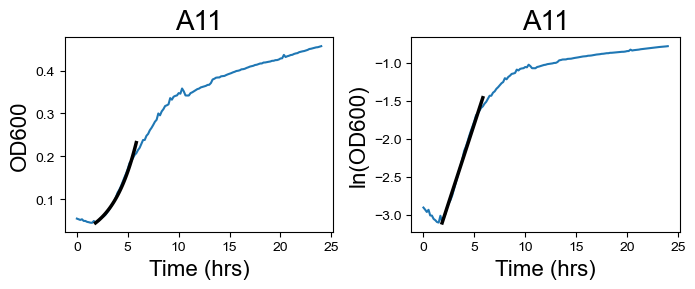

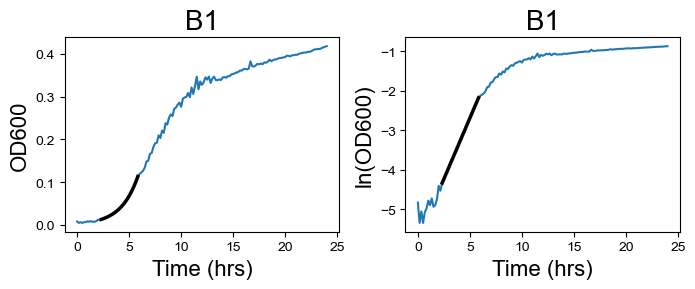

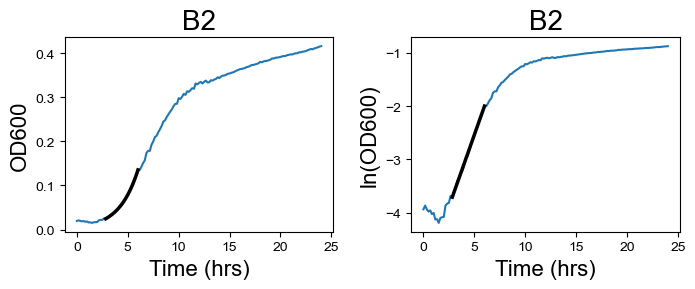

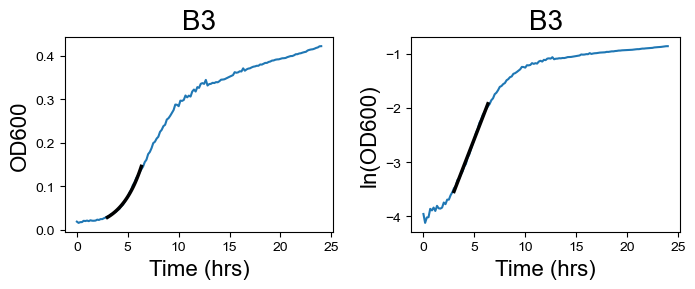

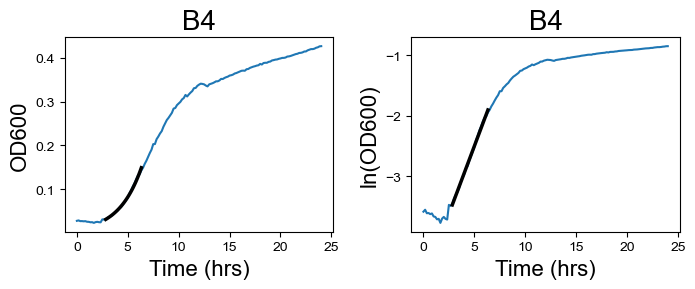

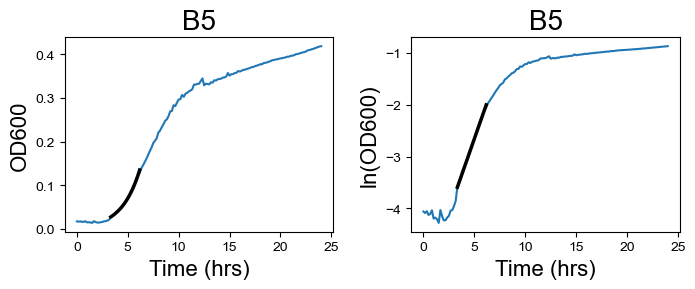

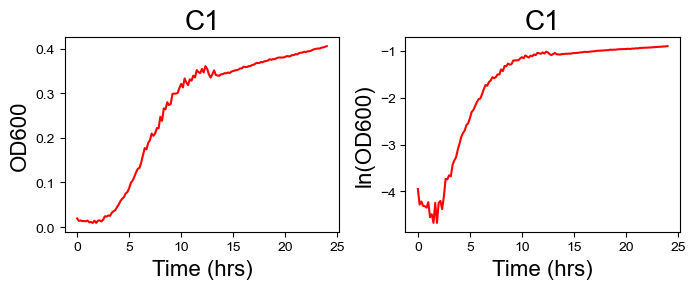

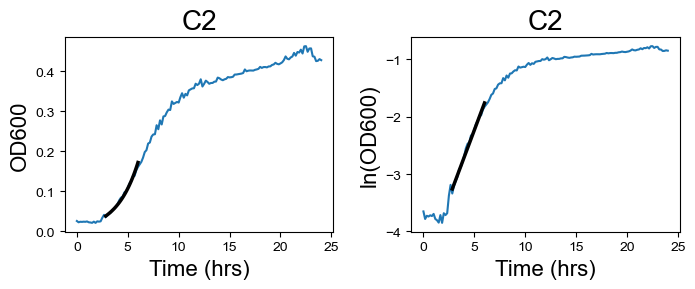

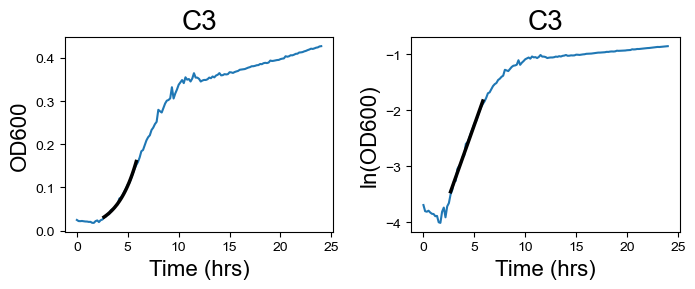

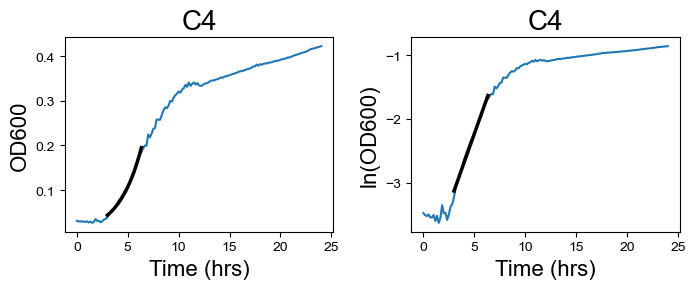

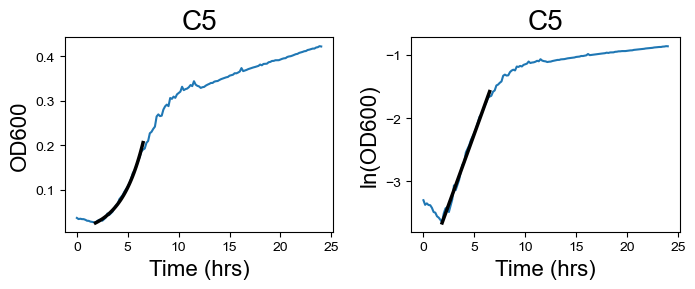

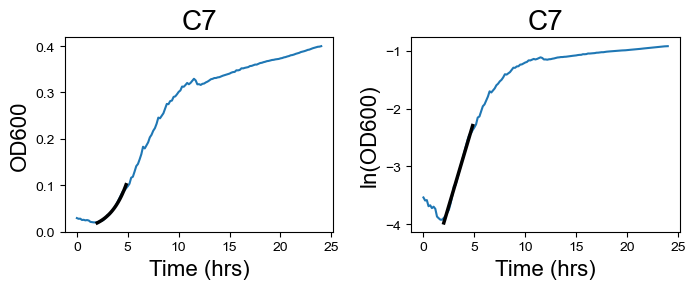

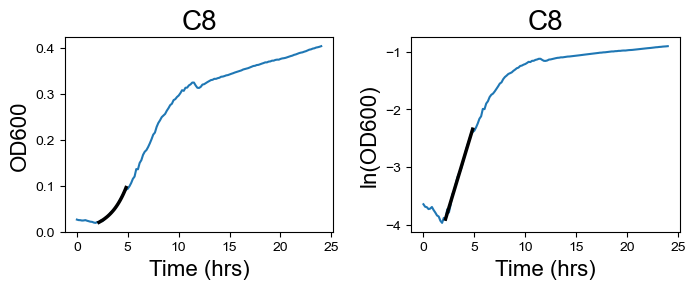

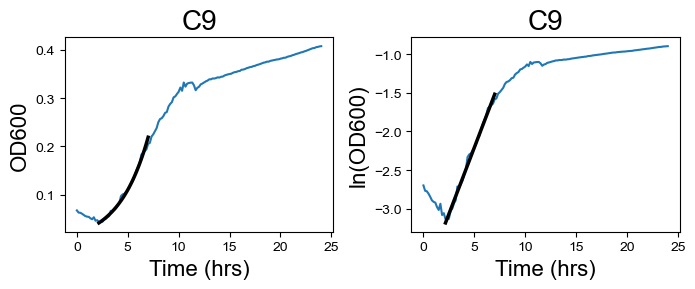

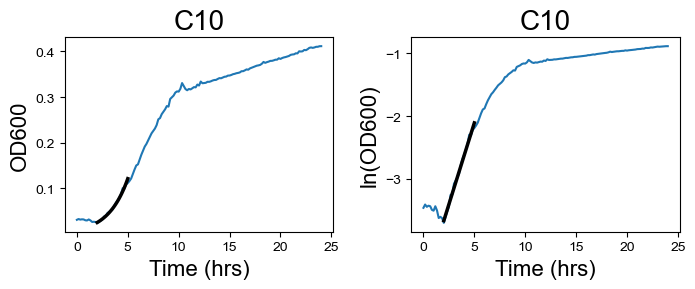

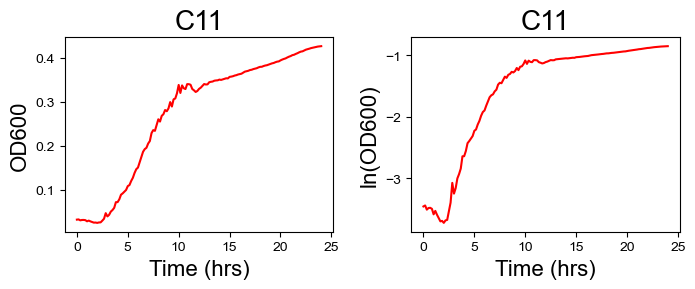

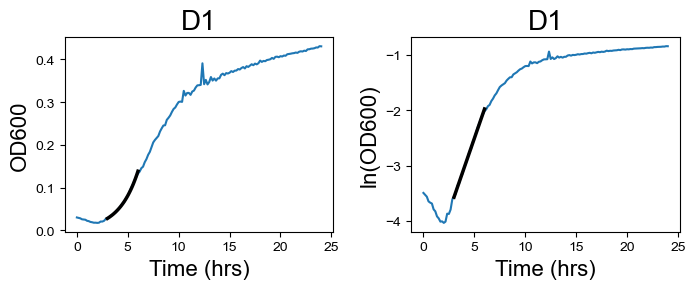

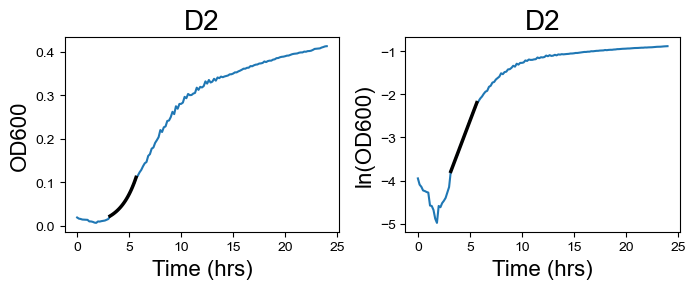

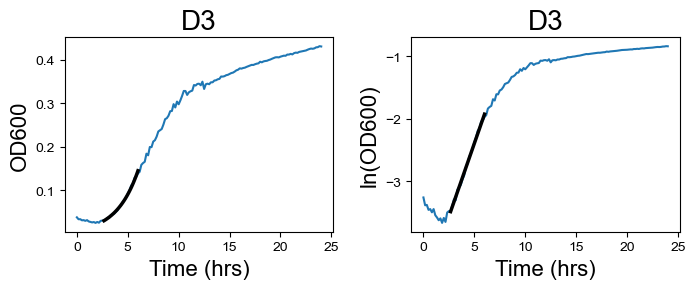

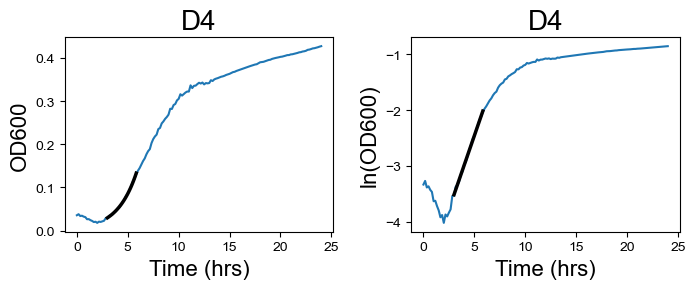

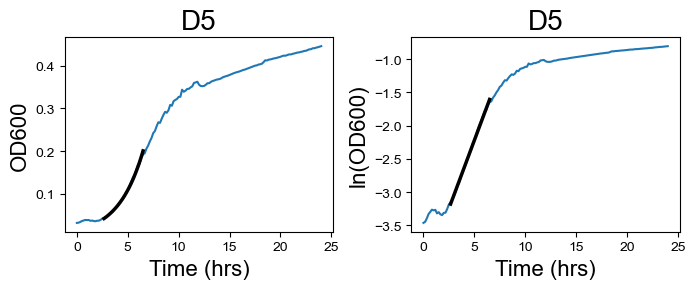

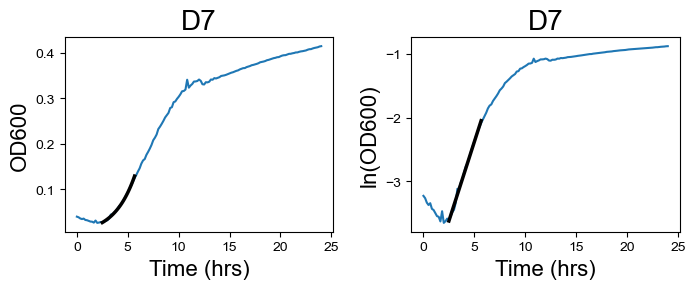

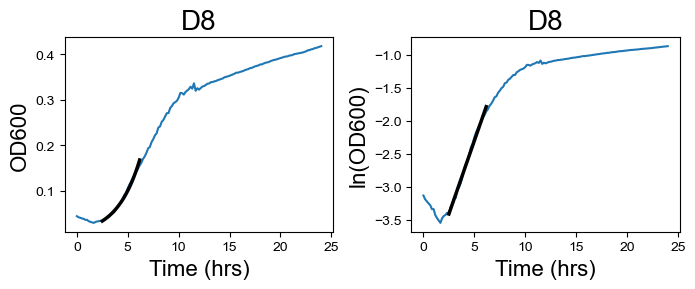

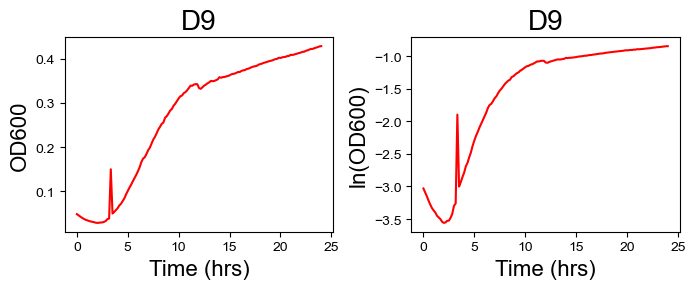

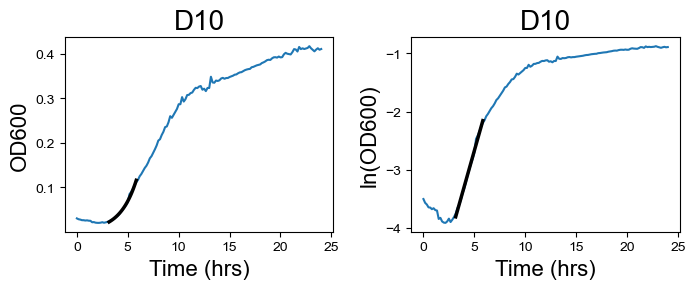

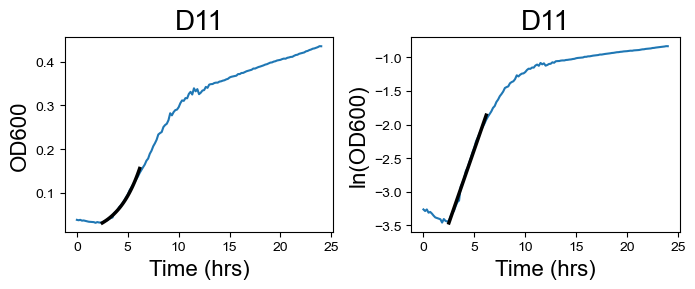

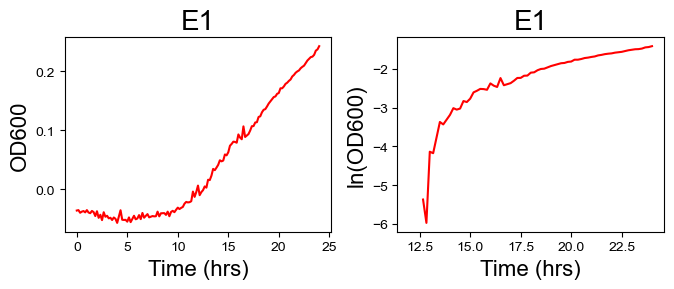

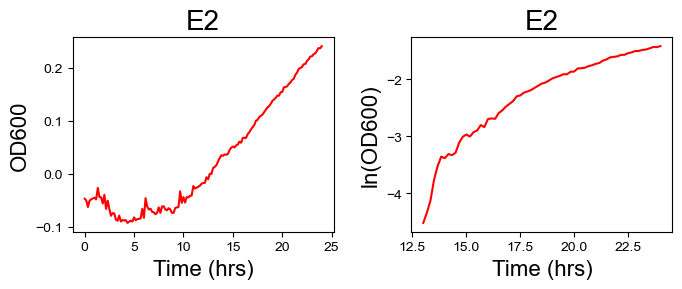

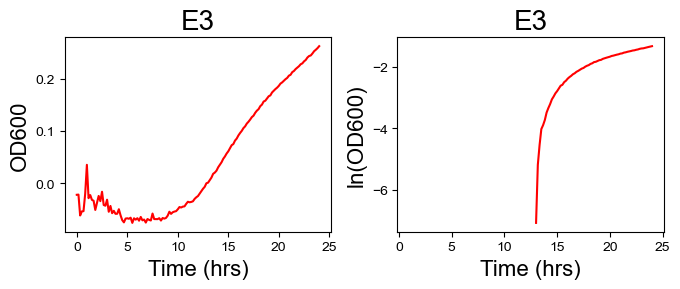

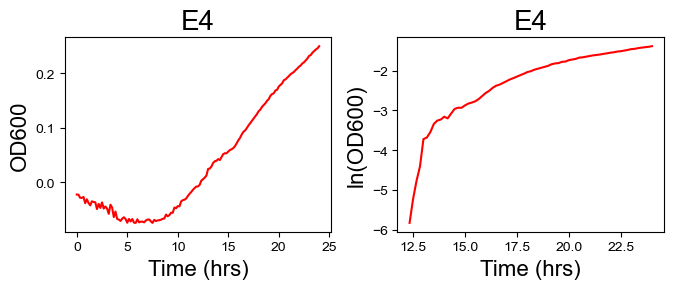

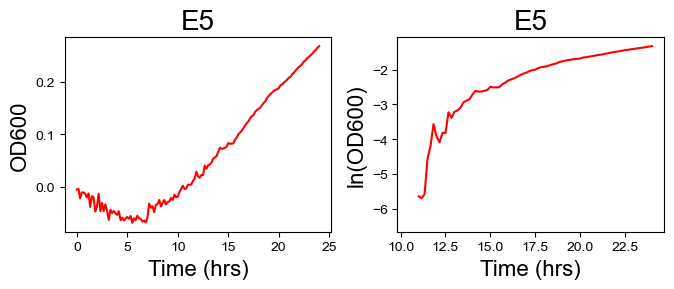

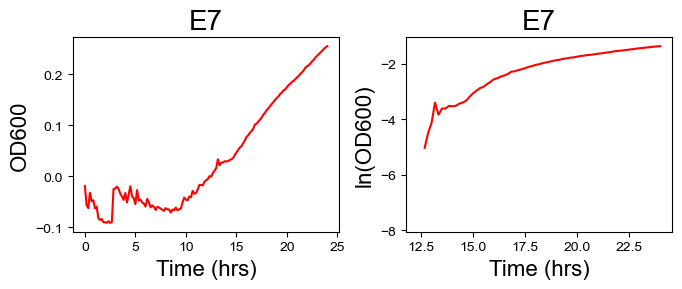

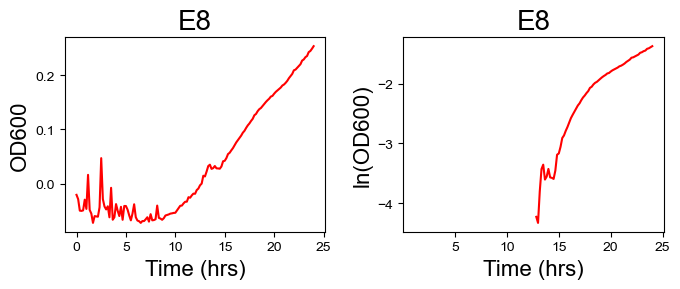

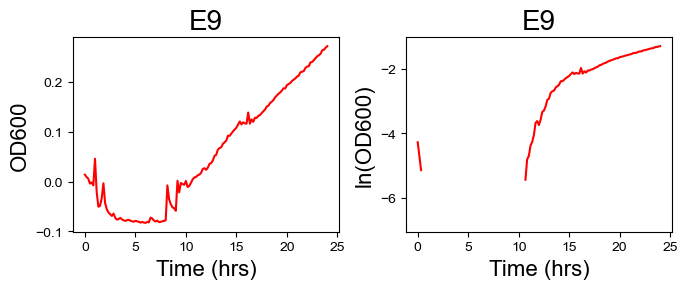

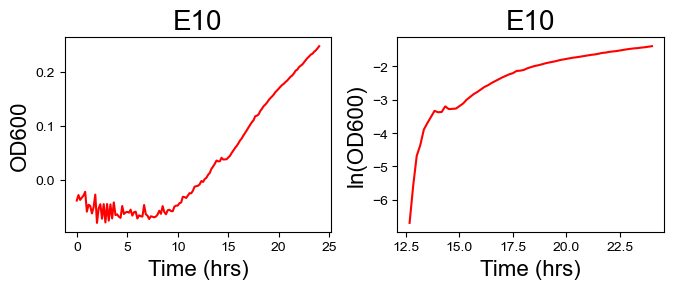

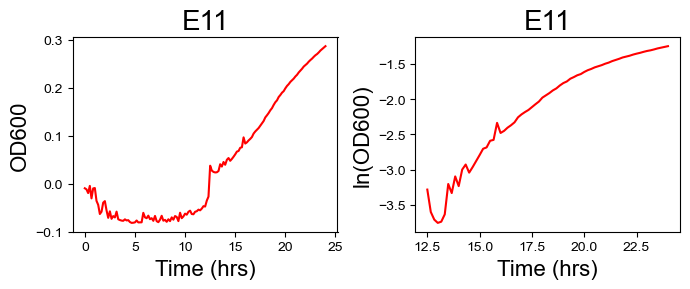

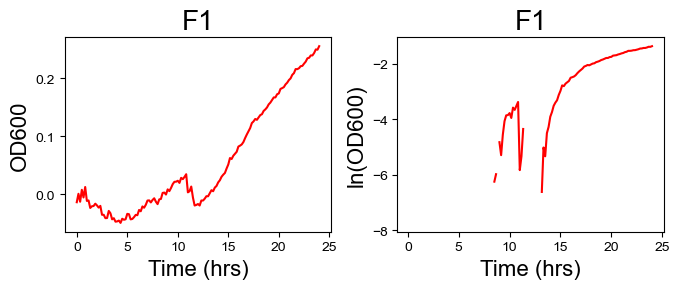

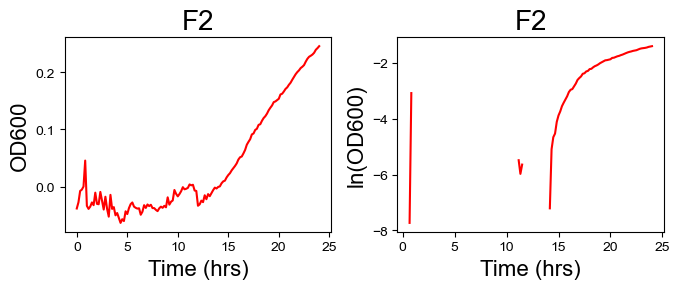

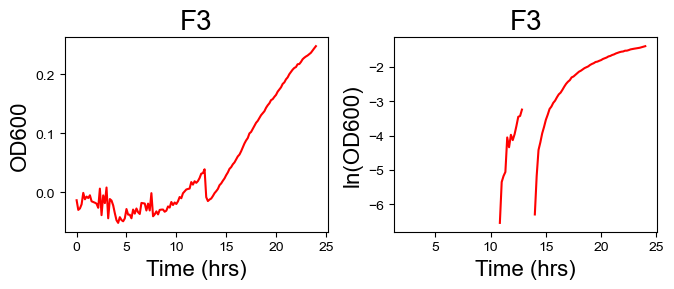

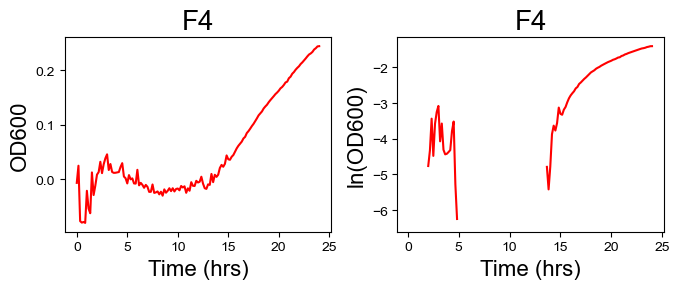

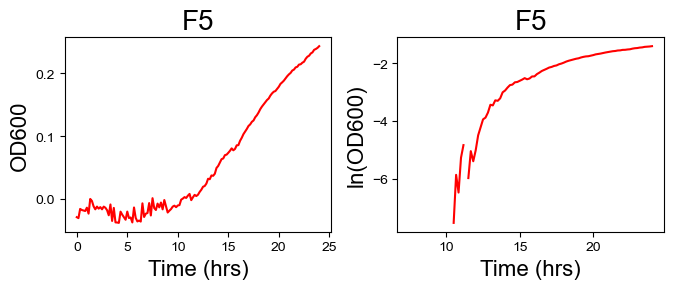

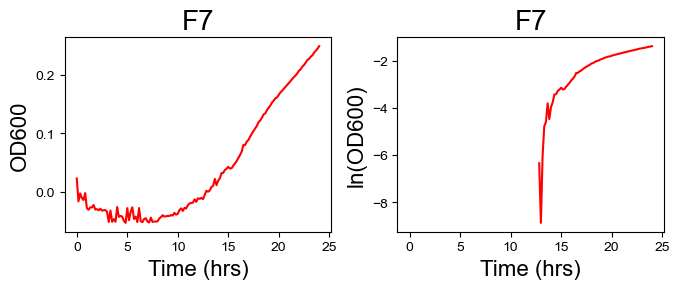

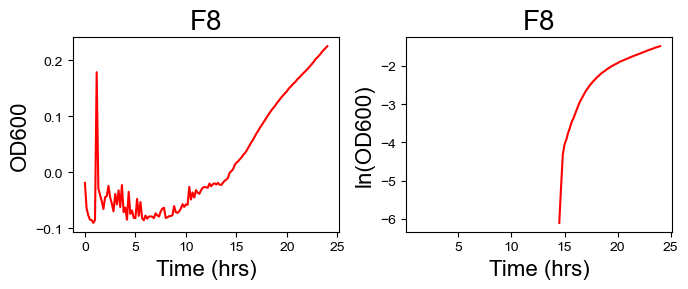

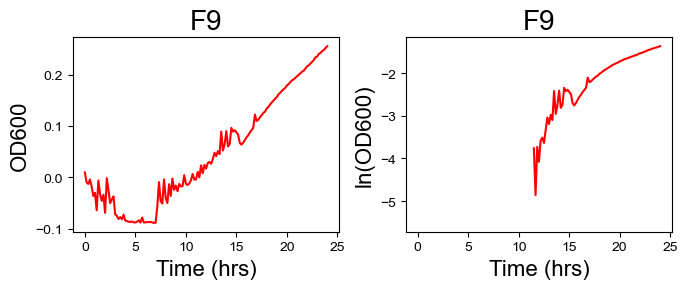

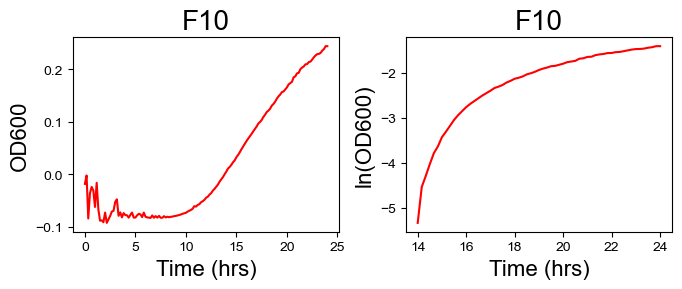

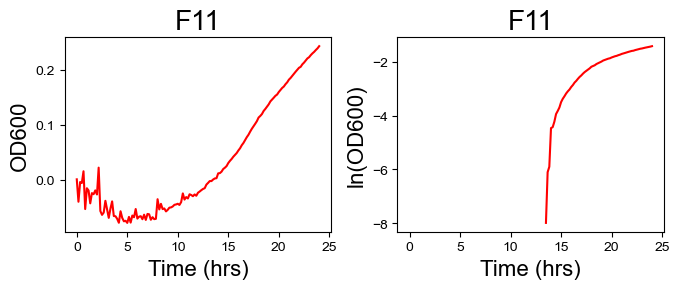

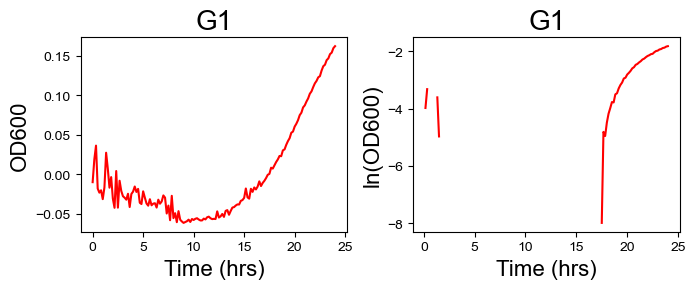

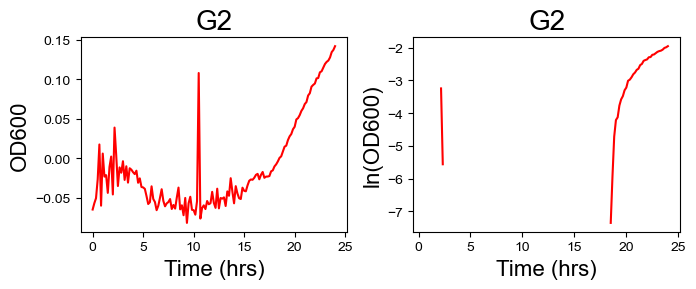

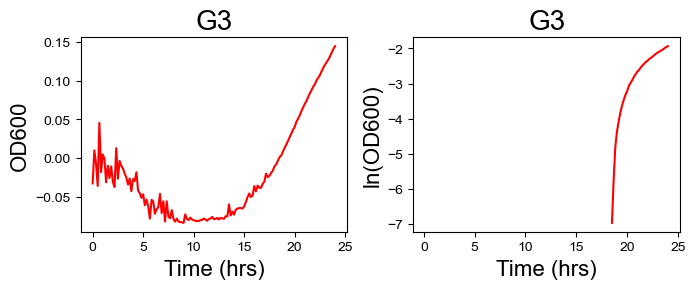

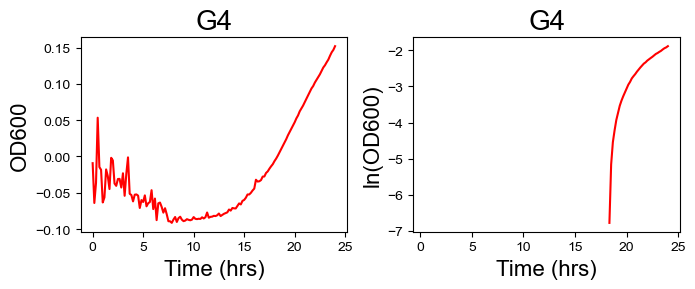

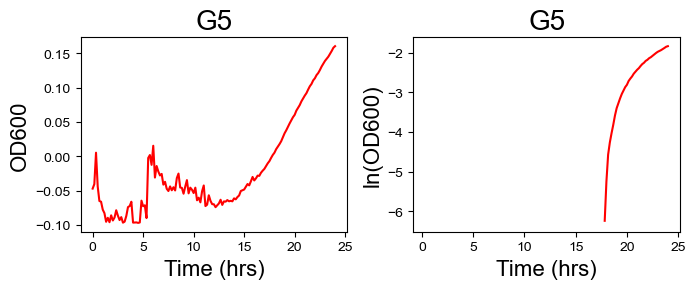

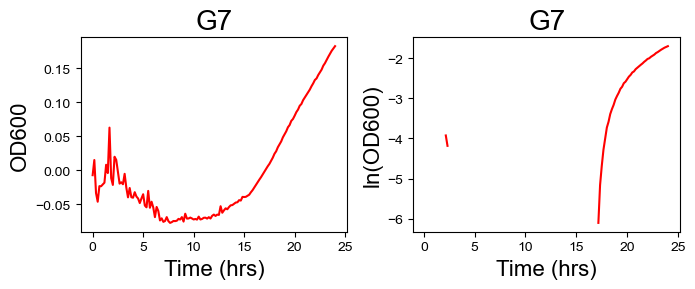

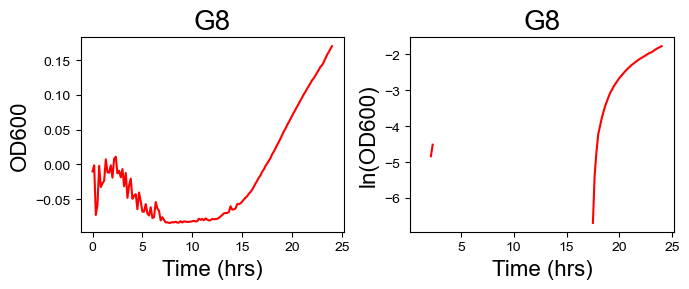

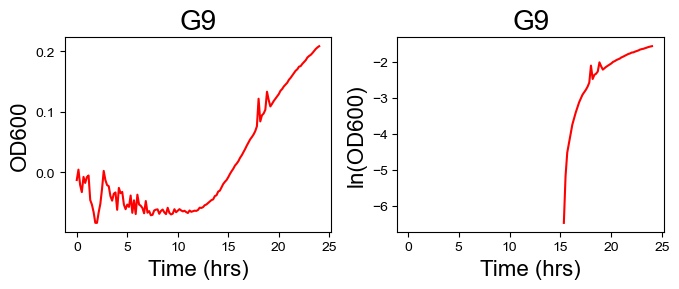

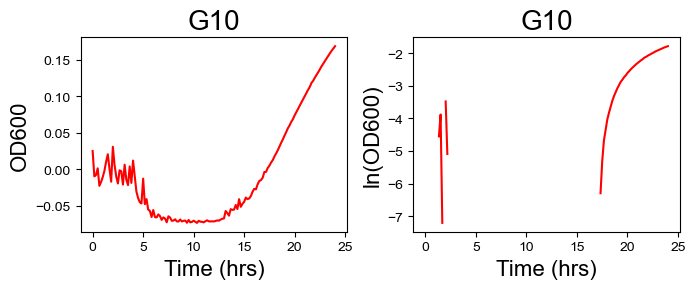

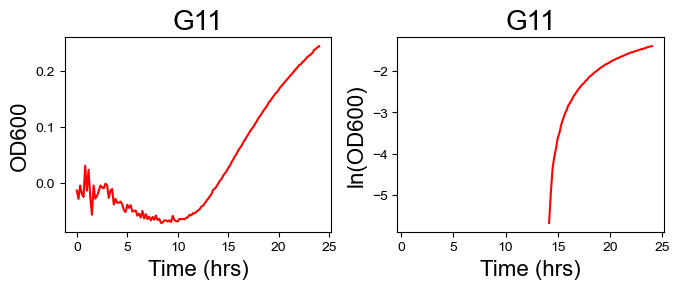

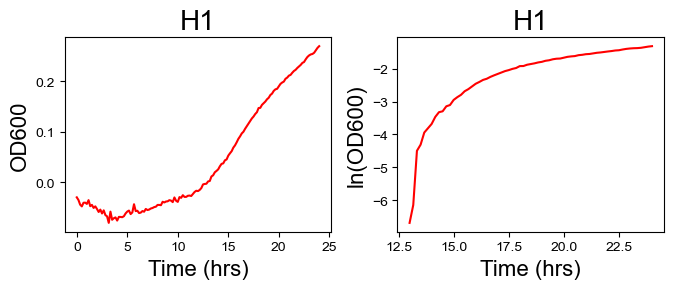

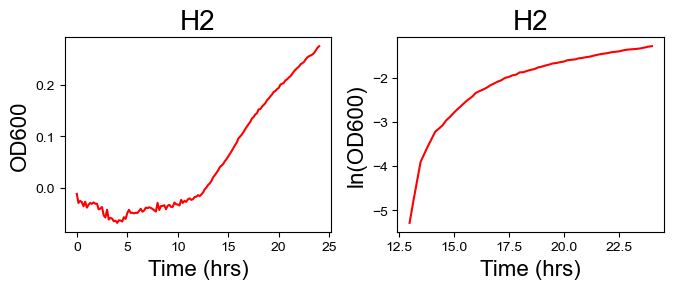

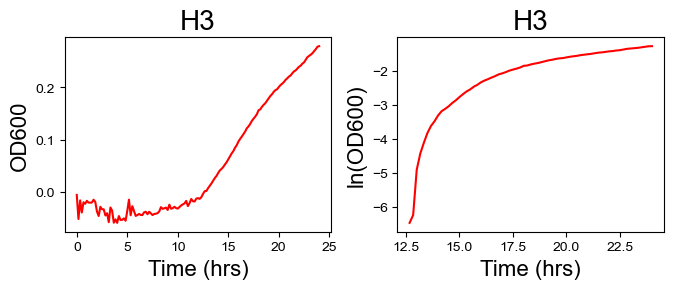

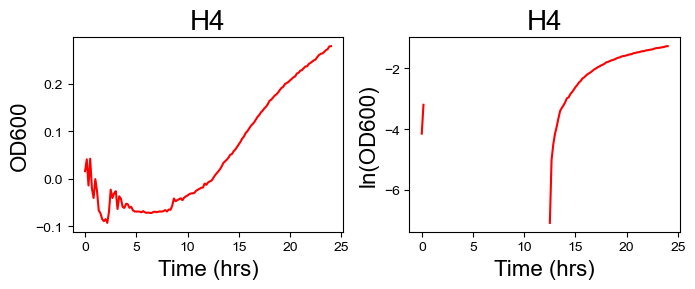

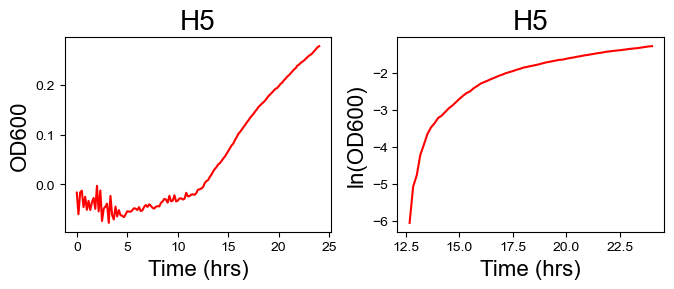

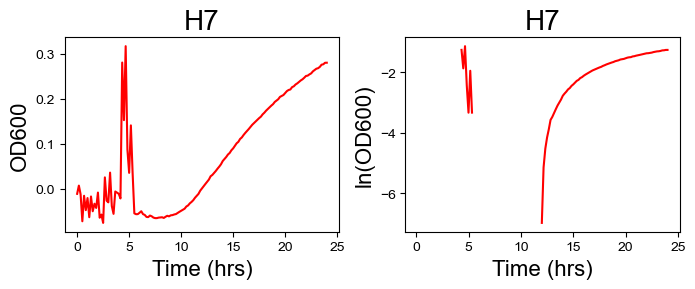

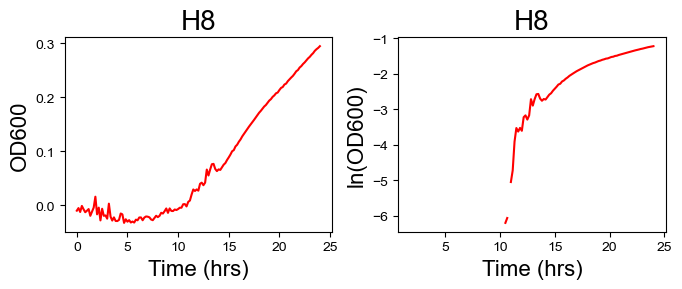

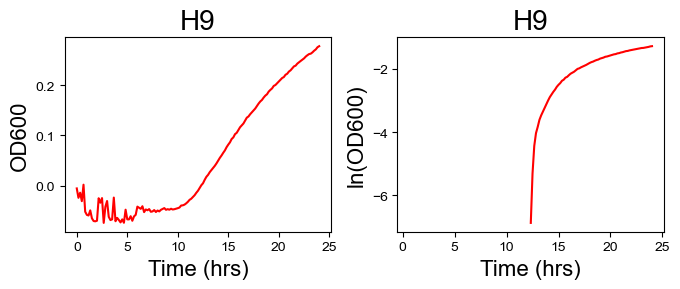

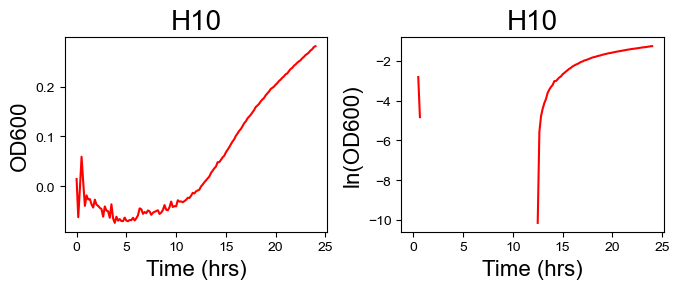

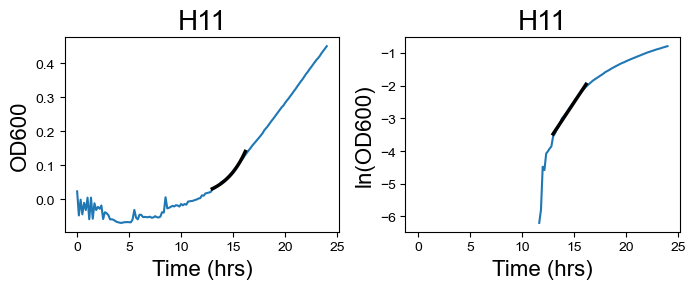

In [116]:
#Plotting module


import math
matplotlib.rcParams['font.sans-serif'] = "Arial"
matplotlib.rcParams['font.family'] = "sans-serif"


def regression_plotter(df_sparams, df_kinetic):
    """
    Input: Dataframes with important data
    
    Output: Plot of all sigmoid fits from one plate; plots of individual samples grouped in replicates
    """   
    import matplotlib.pyplot as plt
    import numpy as np
    from cycler import cycler
        
    xspace = np.linspace(0, max(df_kinetic['Time']), len(df_kinetic.Time)*5)
    plt.figure()
    
    def g(xspace, fit_row):
        return np.exp(fit_row['slopes']*xspace+fit_row['intercepts'])
    
    def plot_ind_fits():
        
        assay = None
        for well in df_kinetic['Well'].unique():
            fit = df_sparams.loc[well]
            assay = fit['Assay']
            df_k = df_kinetic.rowtrieve('Well', well).rowtrieve('Assay',assay)
            
            fig = plt.figure(figsize=(7,3))
            
            ax1 = fig.add_subplot(1,2,1)
            ax1.set_xlabel('Time (hrs)', fontsize=16)
            ax1.set_ylabel('OD600', fontsize=16)
            ax1.set_title(well, fontsize=20)
            ax1.plot(df_k['Time'], df_k['Value'])      
        
            ax2 = fig.add_subplot(1,2,2)
            ax2.set_xlabel('Time (hrs)', fontsize=16)
            ax2.set_ylabel('ln(OD600)', fontsize=16)
            ax2.set_title(well, fontsize=20)  
            ax2.plot(df_k['Time'], np.log(df_k['Value'].astype('float64')))
            
            if fit.loc['slopes':'xStop'].any():
                time_window = [fit['xStart'],fit['xStop']]
                xspace =  np.linspace(time_window[0], time_window[1],
                                  math.ceil((time_window[1]-time_window[0])*20))

                ax1.plot(xspace, g(xspace, fit),\
                         color='k', linewidth=2.5)    
                ax2.plot(xspace, fit['slopes']*xspace+fit['intercepts'],\
                     color='k', linewidth=2.5)
                
            else:
                for ax in plt.gcf().axes:
                    ax.get_lines()[0].set_color("red")
            
            plt.tight_layout()
            
    plot_ind_fits()


def bar_plotter(df_means_stds, colors, title, ylabel, ylim, ordered=False):
    """
    Input: df_param_means_stds, colors
    Output: Bar plots of each parameter with error bars as standard deviations
    """
    import matplotlib.pyplot as plt
    
    plt.style.use('default')
    font_size = 8
    
    fig = plt.figure(figsize=(7,5))

    ax1 = fig.add_subplot(1,1,1)
    
    ax1.set_ylim(ylim)
    
    print(colors)
    
    if ordered==False:
        for sample in df_means_stds.columns:
            ax1.bar(sample, df_means_stds[sample].iloc[0], align='center', yerr = df_means_stds[sample].iloc[1],\
                capsize=3.5,\
                    color=colors\
                   )
        ax1.set_xticklabels(df_means_stds.columns, rotation = 90, fontsize = font_size*1.4)

    if ordered==True:
        ax1.bar(df_means_stds.columns, df_means_stds.iloc[0], align='center', yerr = df_means_stds.iloc[1],\
                capsize=3.5,\
                    color=colors)
        ax1.set_xticklabels(df_means_stds.columns, rotation = 90, fontsize = font_size*1.4)

    ax1.set_xlabel('Sample', fontsize = font_size*1.5)
    ax1.set_ylabel(ylabel, fontsize = font_size*1.5)
    ax1.set_title(title, fontsize = font_size*1.5)
    
    plt.tight_layout()
    plt.show()

# bar_plotter(df_param_means, df_param_stds, colors)

def line_plotter(df_all_k_avg, df_all_k_std):
    """
    Input: pd.dataframes for each parameter average and standard deviation, indexed by plate or day
    
    Output: Line plot for each parameter
    """
    import matplotlib.pyplot as plt      
    
    plt.style.use('default')
    font_size = 8
    colors = colorator(samples, 1)
    
    def grouped_replicates():
        """Graphs individually-passaged replicates together"""
        ax = df_all_k_avg.plot(yerr = df_all_k_std, color = colors, capsize=3.5, figsize=(15,6))
        ax.legend(bbox_to_anchor=(1.4, 0.9))
        ax.set_xlabel('Days of consecutive passaging', fontsize = font_size*1.6)
        ax.set_ylabel('Growth rate (/hr)', fontsize = font_size*2)
        ax.set_title('Growth rate of ESW fits', fontsize = font_size*2.5)

    def grouped_replicates_control_split():
        """Graphs individually-passaged replicates together"""
        ax1 = df_all_k_avg.iloc[:,:5].plot(yerr = df_all_k_std.iloc[:,:5], color = colors, capsize=3.5)
        ax1.legend(bbox_to_anchor=(1.4, 0.9))
        ax1.set_xlabel('Days of consecutive passaging', fontsize = font_size*1.6)
        ax1.set_ylabel('Growth rate (/hr)', fontsize = font_size*2)
        ax1.set_title('Growth rate of ESW fits', fontsize = font_size*2.5)
        ax1.set_ylim(0.1,0.9) 
        
        ax2 = df_all_k_avg.iloc[:,5:].plot(yerr = df_all_k_std.iloc[:,5:], color = colors[5:], capsize=3.5)
        ax2.legend(bbox_to_anchor=(1.4, 0.9))
        ax2.set_xlabel('Days of consecutive passaging', fontsize = font_size*1.6)
        ax2.set_ylabel('Growth rate (/hr)', fontsize = font_size*2)
        ax2.set_title('Growth rate of ESW fits', fontsize = font_size*2.5)
        ax2.set_ylim(0.1,0.9) 
        
    def individual_wells():
        """Graphs lineage of each well, colored by replicate"""
        
        ax = df_k_inds.plot(color = colors)
        ax.legend(bbox_to_anchor=(1.4, 0.9))
        
        ax.set_xlabel('Days of consecutive passaging', fontsize = font_size*1.6)
        ax.set_ylabel('Growth rate (/hr)', fontsize = font_size*2)
        ax.set_title('Growth rate of ESW fits', fontsize = font_size*2.5)
        
        
    grouped_replicates()
    grouped_replicates_control_split()
    individual_wells()
    
# line_plotter(df_all_L_avg, df_all_L_std, df_all_k_avg, df_all_k_std, df_all_x0_avg, df_all_x0_std)
regression_plotter(df_fits,df_reps)